# LST derived from Landsat 8 images and rescaled to 10 m resolution

This notebook contains the code to use Landsat 8 images to estimate LST of Sentinel 2 images.

The workflow is as follow:

1. Get Lansat 8 and Sentinel 2 image collections.
2. 

In [1]:
import ee
import pandas as pd
from janitor import clean_names
from datetime import timedelta
import pyproj
from IPython.display import Image

In [2]:
ee.Initialize()

In [3]:
# Read leak df to get dates
leaks_raw = pd.read_excel("../data/raw/Ordenes Fugas Ejecutadas Dic2022 XY.xlsx")
leaks_raw.head()

# Clean leaks data
leaks_clean = clean_names(leaks_raw)
leaks_clean.columns # The column of interest is fecha_de_inicio

# First we need to filter leaks that are detected in the main pipe. Code in column nombretrabajo: FTC

# Column with codes
leaks_clean["leak_type"] = leaks_clean.nombretrabajo.str.extract(r"([A-Z]+)", expand = False)

# Filter
leaks_clean = leaks_clean.query("leak_type == 'FTC'")

# Second, we need to filter to causal == "SE REPARA FTC, GENERA BA"
leaks_clean = leaks_clean.query("causal == 'SE REPARA FTC, GENERA BA'")

# Drop irrelevant columns
leaks_clean = leaks_clean.drop(["codunidad", "nombreestado", "nombretrabajo", "fecha_de_creacion"], axis = 1)

# Sort df by fecha_de_inicio
leaks_clean = leaks_clean.sort_values(by = "fecha_de_inicio").reset_index(drop = True)

# Show clean df 
leaks_clean # This df is going to be necessary to define the date of each image to be downloaded

,id,fecha_de_inicio,fecha_final,fechalegalizacion,causal,x,y,leak_type
0,2366,2022-12-01,2022-12-01,2022-12-01,"SE REPARA FTC, GENERA BA",781563.335110,2.419492e+06,FTC
1,2479,2022-12-01,2022-12-01,2022-12-01,"SE REPARA FTC, GENERA BA",785033.684233,2.423310e+06,FTC
2,2443,2022-12-01,2022-12-01,2022-12-01,"SE REPARA FTC, GENERA BA",781521.553633,2.419196e+06,FTC
3,2460,2022-12-02,2022-12-02,2022-12-02,"SE REPARA FTC, GENERA BA",779658.087686,2.416386e+06,FTC
4,2409,2022-12-02,2022-12-02,2022-12-02,"SE REPARA FTC, GENERA BA",781491.668852,2.419196e+06,FTC
5,2408,2022-12-02,2022-12-02,2022-12-02,"SE REPARA FTC, GENERA BA",781485.487216,2.419196e+06,FTC
6,2356,2022-12-05,2022-12-05,2022-12-06,"SE REPARA FTC, GENERA BA",775485.422490,2.421585e+06,FTC
7,2384,2022-12-08,2022-12-08,2022-12-26,"SE REPARA FTC, GENERA BA",784867.434927,2.421415e+06,FTC
8,2522,2022-12-14,2022-12-14,2022-12-16,"SE REPARA FTC, GENERA BA",778240.410614,2.426147e+06,FTC
9,2398,2022-12-17,2022-12-17,2022-12-24,"SE REPARA FTC, GENERA BA",786021.811978,2.420745e+06,FTC


In [4]:
# Parameters for collection

leak = 0 # Id of leak in df

leak_lat_ogcrs = leaks_clean["y"][leak]
leak_lon_ogcrs = leaks_clean["x"][leak]

# Transform to degrees
transformer = pyproj.Transformer.from_crs("epsg:32613", "epsg:4326")
leak_lon, leak_lat = transformer.transform(leak_lon_ogcrs, leak_lat_ogcrs)

# Point of leak
poi = ee.Geometry.Point([leak_lat, leak_lon])

# Dates
end_date = leaks_clean.fechalegalizacion[leak] - timedelta(days = 1)
start_date = end_date - timedelta(days = 7)

print("inicio:", start_date, "\nfinal:", end_date)

inicio: 2022-11-23 00:00:00 
final: 2022-11-30 00:00:00


## Landsat 8 image collection

In [19]:
# Change this to LC08 if Landsat 8 is required

selected_Landsat_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")\
                                .filterBounds(poi)\
                                .filterDate(ee.Date(start_date), ee.Date(end_date))\
                                .sort("CLOUD_COVER")

selected_S2_collection = ee.ImageCollection("COPERNICUS/S2_SR")\
                                .filterBounds(poi)\
                                .filterDate(ee.Date(start_date), ee.Date(end_date))\
                                .sort("CLOUDY_PIXEL_PERCENTAGE")

landsat_list = selected_Landsat_collection.toList(selected_Landsat_collection.size())
sentinel_list = selected_S2_collection.toList(selected_S2_collection.size())

img_landsat = selected_Landsat_collection.first()
img_sentinel = selected_S2_collection.first()

print("Date of selected image (Landsat):", ee.Date(img_landsat.get("system:time_start")).format("yyyy-MM-dd").getInfo(),
      "\nNubosidad: ", img_landsat.get("CLOUD_COVER").getInfo())
print("Date of selected image (Sentinel):", ee.Date(img_sentinel.get("system:time_start")).format("yyyy-MM-dd").getInfo(),
      "\nNubosidad: ", img_sentinel.get("CLOUDY_PIXEL_PERCENTAGE").getInfo())

Date of selected image (Landsat): 2022-11-26 
Nubosidad:  3.62
Date of selected image (Sentinel): 2022-11-28 
Nubosidad:  None


In [6]:
buff_size = 100
display(Image(url = img_landsat.clip(poi.buffer(buff_size).bounds(proj = "EPSG:32613", maxError = 0.001)).getThumbURL(
                                               {
                                                "dimensions": 800,
                                                "bands": ["SR_B4", "SR_B3", "SR_B2"],
                                                "gamma": 1})))

display(Image(url = img_sentinel.clip(poi.buffer(buff_size).bounds(proj = "EPSG:32613", maxError = 0.001)).getThumbURL(
                                               {"min": 0,
                                                "max": 3000,
                                                "dimensions": 800,
                                                "bands": ["B4", "B3", "B2"]})))

In [8]:
# Create compound bands in order to perform linear regression
ndvi_landsat = img_landsat.normalizedDifference(["SR_B5", "SR_B4"]).rename("ndvi")
ndwi_landsat = img_landsat.normalizedDifference(["SR_B3", "SR_B5"]).rename("ndwi")
ndbi_landsat = img_landsat.normalizedDifference(["SR_B6", "SR_B5"]).rename("ndbi")
lst_landsat_30m = img_landsat.select("ST_B10").rename("Landsat_LST_30m")

ndvi_sentinel = img_sentinel.normalizedDifference(["B8", "B4"]).rename("s2_ndvi")
ndwi_sentinel = img_sentinel.normalizedDifference(["B3", "B11"]).rename("s2_ndwi")
ndbi_sentinel = img_sentinel.normalizedDifference(["B11", "B8"]).rename("s2_ndbi")

In [10]:
# Linear regression
bands = ee.Image(1).addBands(ndvi_landsat).addBands(ndbi_landsat).addBands(ndwi_landsat).addBands(lst_landsat_30m).rename(["constant", "ndvi", "ndbi", "ndwi", "lst"])

img_landsat_regression = bands.reduceRegion(
    reducer = ee.Reducer.linearRegression(4, 1),
    geometry = poi.buffer(buff_size).bounds(proj = "EPSG:32613", maxError = 0.001),
    scale = 30,
    maxPixels = 1e13
)

coefList2 = ee.Array(img_landsat_regression.get("coefficients")).toList()
intercept2 = ee.Image(ee.Number(ee.List(coefList2.get(0)).get(0))).reproject(crs = "EPSG:32613")
intercept2_list = ee.List(coefList2.get(0)).get(0)
slopeNDVI2 = ee.Image(ee.Number(ee.List(coefList2.get(1)).get(0))).reproject(crs = "EPSG:32613")
slopeNDVI2_list =  ee.List(coefList2.get(1)).get(0)
slopeNDBI2 = ee.Image(ee.Number(ee.List(coefList2.get(2)).get(0))).reproject(crs = "EPSG:32613")
slopeNDBI2_list =  ee.List(coefList2.get(2)).get(0)
slopeNDWI2 = ee.Image(ee.Number(ee.List(coefList2.get(3)).get(0))).reproject(crs = "EPSG:32613")
slopeNDWI2_list =  ee.List(coefList2.get(3)).get(0)

In [11]:
# Downscale landsat image to 10m

# Estimate first image
lst_landsat_10m1 = ee.Image(intercept2).add(slopeNDVI2.multiply(ndvi_sentinel)).add(slopeNDBI2.multiply(ndbi_sentinel).add(slopeNDWI2.multiply(ndwi_sentinel)))

# Create model 
LST_model = intercept2.add(slopeNDVI2.multiply(ndvi_landsat))\
              .add(slopeNDBI2.multiply(ndbi_landsat))\
              .add(slopeNDWI2.multiply(ndwi_landsat)).clip(poi.buffer(buff_size).bounds(proj = "EPSG:32613", maxError = 0.001))

# Get residuals
residuals = lst_landsat_30m.subtract(LST_model)

# Define gaussian kernel in order to perform convolution for image smoothness
gaussian = ee.Kernel.gaussian(radius = 1.5, units = "pixels")

# Apply convolution 
residuals_gaussian = residuals.resample("bicubic").convolve(gaussian)

# Final downscaled image
lst_landsat_10m_final = ee.Image(intercept2).add(slopeNDVI2.multiply(ndvi_sentinel))\
                                            .add(slopeNDBI2.multiply(ndbi_sentinel)).add(slopeNDWI2.multiply(ndwi_sentinel))

lst_landsat_10m_final_residuals = lst_landsat_10m_final.add(residuals_gaussian)

In [25]:
def add_lst10m_band(sentinel_image, lst_image):
    
    return sentinel_image.addBands(lst_image.rename("LST_10m"))
    

In [26]:
img_sentinel_lst = add_lst10m_band(sentinel_image = img_sentinel, lst_image = lst_landsat_10m_final_residuals)
img_sentinel_lst.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL',
 'TCI_R',
 'TCI_G',
 'TCI_B',
 'MSK_CLDPRB',
 'MSK_SNWPRB',
 'QA10',
 'QA20',
 'QA60',
 'LST_10m']

In [28]:
# Save lst downscaled image
url = img_sentinel_lst.getDownloadURL({
    "scale": 10,
    "region": poi.buffer(100).bounds(proj = "EPSG:32613", maxError = 0.001),
    "crs": "EPSG:32613",
    "fileFormat": "GeoTIFF",
    "maxPixels": 1e13
})

print(url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c54ecb1f3d44e6781f20230cef0d7c8-52f0d48bebf975f67237bdf8e038cc45:getPixels


In [237]:
from skimage.io import imread
import matplotlib.pyplot as plt
lst_10 = imread("../data/images/lst_10m_10km.tif")
lst_patch = imread("../data/images/lst_patch.tif")
s2_b2 = imread("../data/images/20221210T171721_20221210T172008_T13QGE.B2.tif")

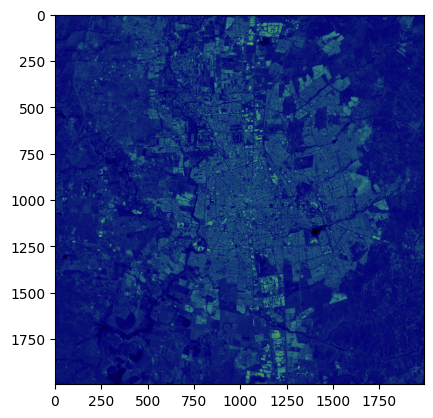

In [224]:
plt.imshow(s2_b2, cmap = "gist_earth")

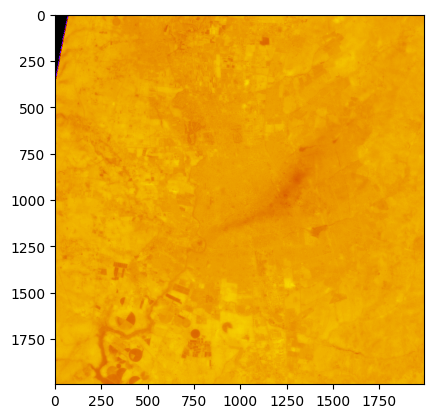

In [225]:
plt.imshow(lst_10, cmap = "gnuplot")

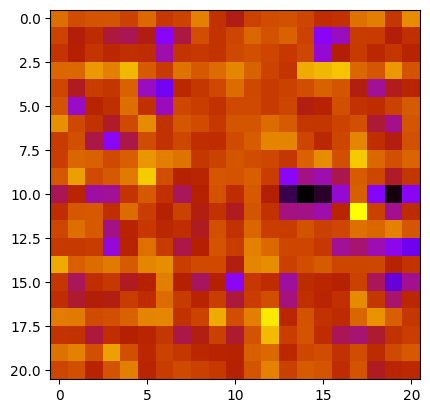

In [238]:
plt.imshow(lst_patch, cmap = "gnuplot")